In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio.datasets import SPEECHCOMMANDS
import os
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoFeatureExtractor
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
from torchaudio.transforms import MelSpectrogram, Spectrogram
import pandas as pd
from sklearn.metrics import confusion_matrix
from IPython.display import Audio, display
from collections import Counter

In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [01:27<00:00, 27.8MB/s]


In [4]:
train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)

train_indices = list(range(train_size))
val_indices = list(range(val_size))
test_indices = list(range(test_size))

train_subset_indices = train_indices[::10]
val_subset_indices = val_indices[::10]
test_subset_indices = test_indices[::10]

In [5]:
from torch.utils.data import Subset

train_set = Subset(train_set, train_subset_indices)
val_set = Subset(val_set, val_subset_indices)
test_set = Subset(test_set, test_subset_indices)

In [6]:
def count_samples_per_class(dataset):
    labels = [datapoint[2] for datapoint in dataset]
    return Counter(labels)

In [7]:
def get_example_per_class(dataset):
    examples = {}
    for waveform, sample_rate, label, *_ in dataset:
        if label not in examples:
            examples[label] = (waveform, sample_rate)
    return examples

In [8]:
def create_spectrogram(waveform, sample_rate):
    mel_transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    return mel_transform(waveform)

In [9]:
def plot_class_distribution():
    train_counts = count_samples_per_class(train_set)
    
    plt.figure(figsize=(15, 6))
    plt.bar(train_counts.keys(), train_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribuição de Classes no Conjunto de Treinamento')
    plt.xlabel('Classes')
    plt.ylabel('Número de Amostras')
    plt.tight_layout()
    plt.show()

    # Imprimir estatísticas
    print("\nEstatísticas do conjunto de dados:")
    print(f"Total de amostras de treinamento: {len(train_set)}")
    print(f"Total de amostras de validação: {len(val_set)}")
    print(f"Total de amostras de teste: {len(test_set)}")
    print("\nDistribuição de classes (treinamento):")
    for label, count in sorted(train_counts.items()):
        print(f"{label}: {count}")

In [10]:
def plot_waveforms_and_spectrograms():
    examples = get_example_per_class(train_set)
    
    # Plotar 5 classes por figura
    n_classes = len(examples)
    n_cols = 2  # waveform e spectrogram
    n_rows = 5
    classes_per_plot = 5
    
    for i in range(0, n_classes, classes_per_plot):
        plt.figure(figsize=(15, 12))
        
        for j, (label, (waveform, sample_rate)) in enumerate(list(examples.items())[i:i+classes_per_plot]):
            # Forma de onda
            plt.subplot(n_rows, n_cols, j*2 + 1)
            plt.plot(waveform.t().numpy())
            plt.title(f'Forma de Onda - {label}')
            plt.xlabel('Amostras')
            plt.ylabel('Amplitude')
            
            # Espectrograma
            plt.subplot(n_rows, n_cols, j*2 + 2)
            specgram = create_spectrogram(waveform, sample_rate)
            plt.imshow(specgram[0].numpy(), aspect='auto', origin='lower')
            plt.title(f'Espectrograma - {label}')
            plt.xlabel('Tempo')
            plt.ylabel('Frequência (Mel)')
            plt.colorbar(format='%+2.0f dB')
        
        plt.tight_layout()
        plt.show()

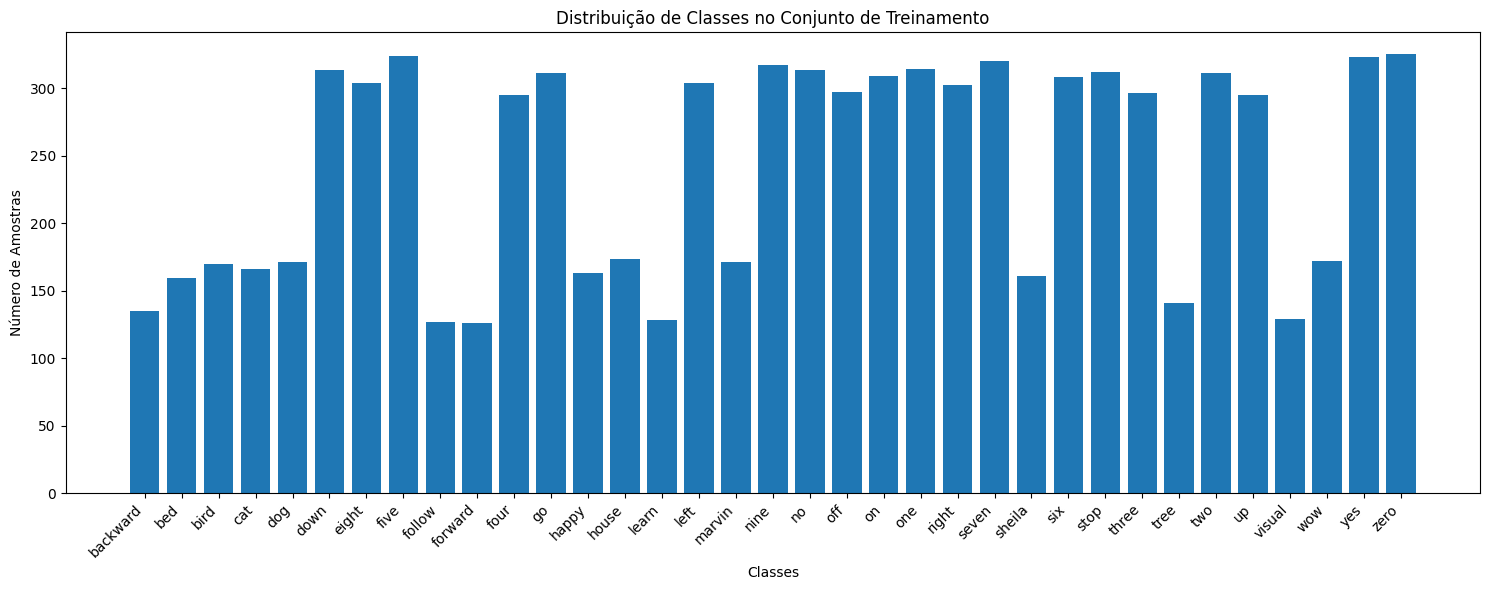


Estatísticas do conjunto de dados:
Total de amostras de treinamento: 8485
Total de amostras de validação: 999
Total de amostras de teste: 1101

Distribuição de classes (treinamento):
backward: 135
bed: 159
bird: 170
cat: 166
dog: 171
down: 313
eight: 304
five: 324
follow: 127
forward: 126
four: 295
go: 311
happy: 163
house: 173
learn: 128
left: 304
marvin: 171
nine: 317
no: 313
off: 297
on: 309
one: 314
right: 302
seven: 320
sheila: 161
six: 308
stop: 312
three: 296
tree: 141
two: 311
up: 295
visual: 129
wow: 172
yes: 323
zero: 325


In [11]:
plot_class_distribution()

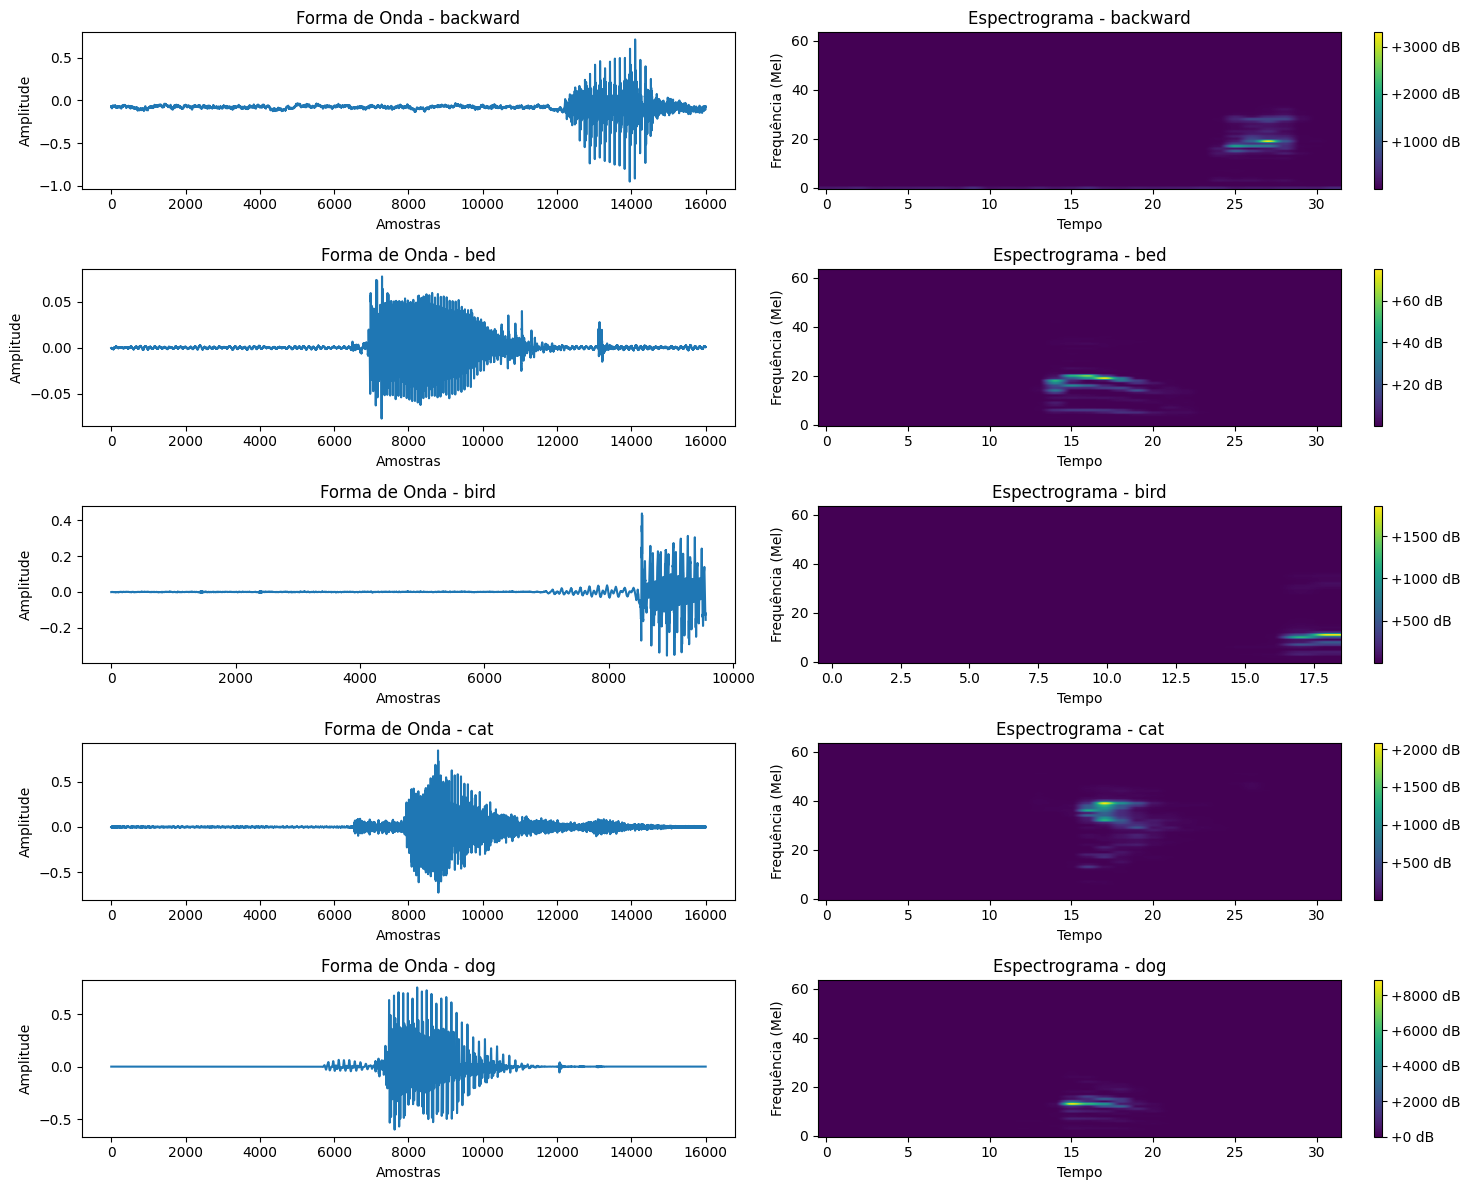

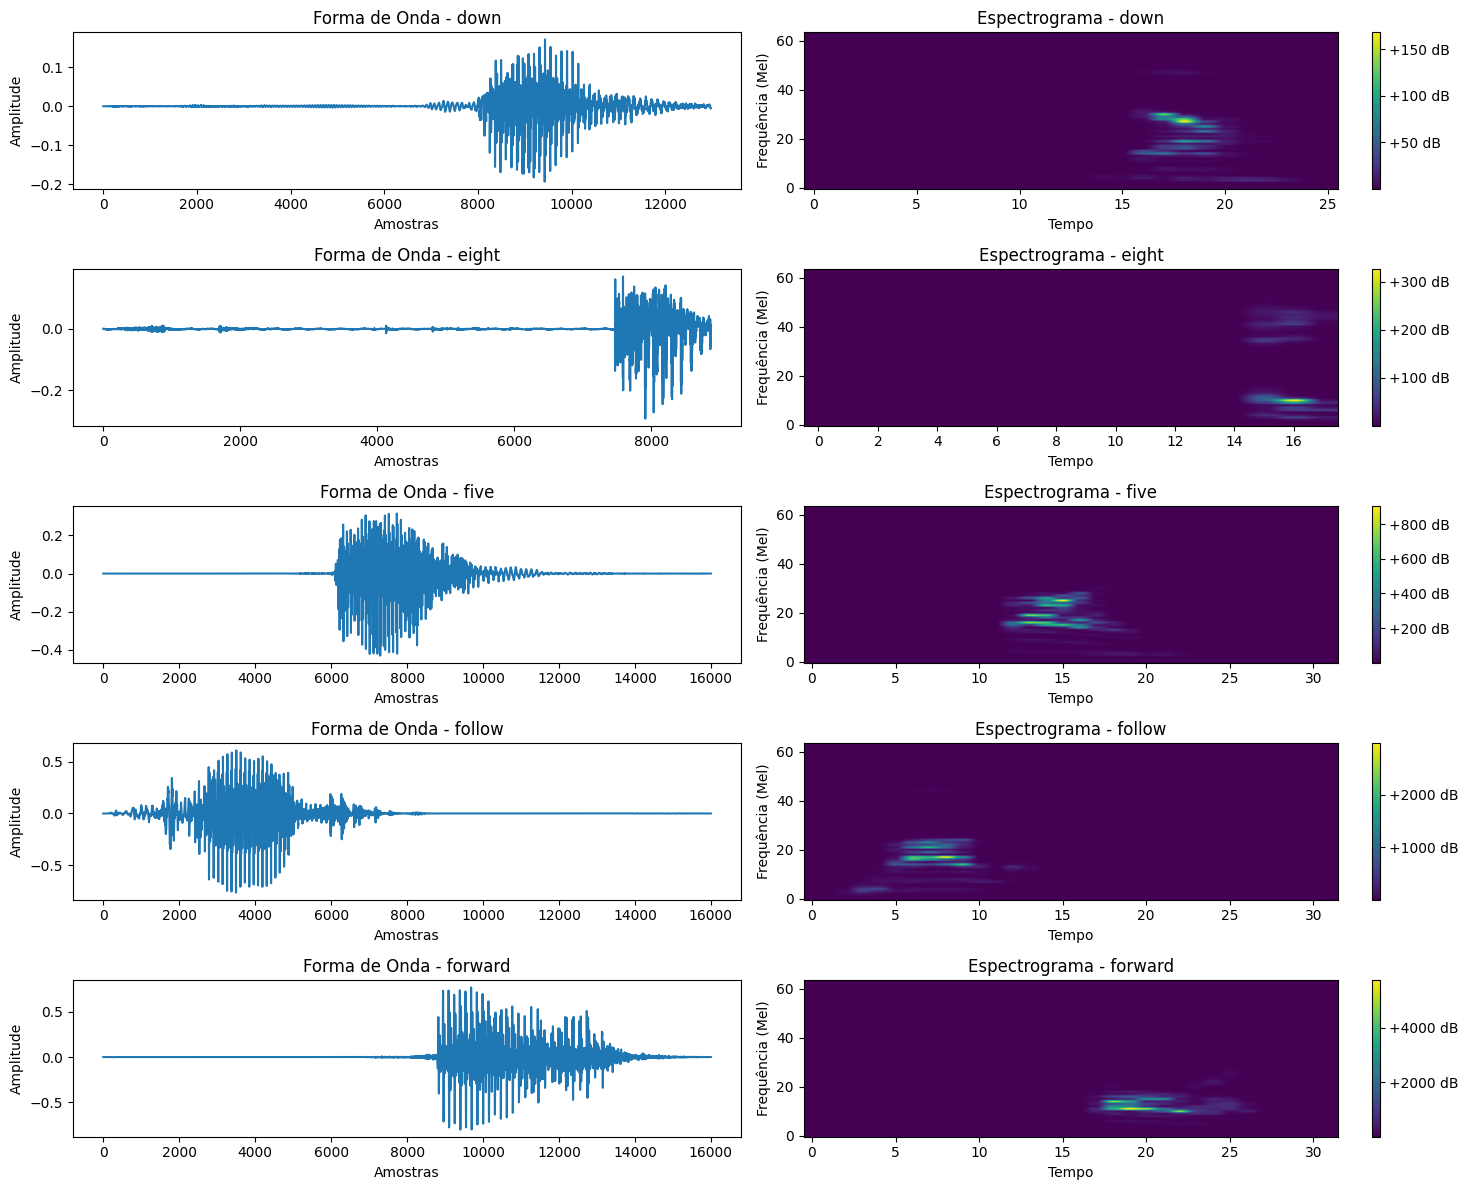

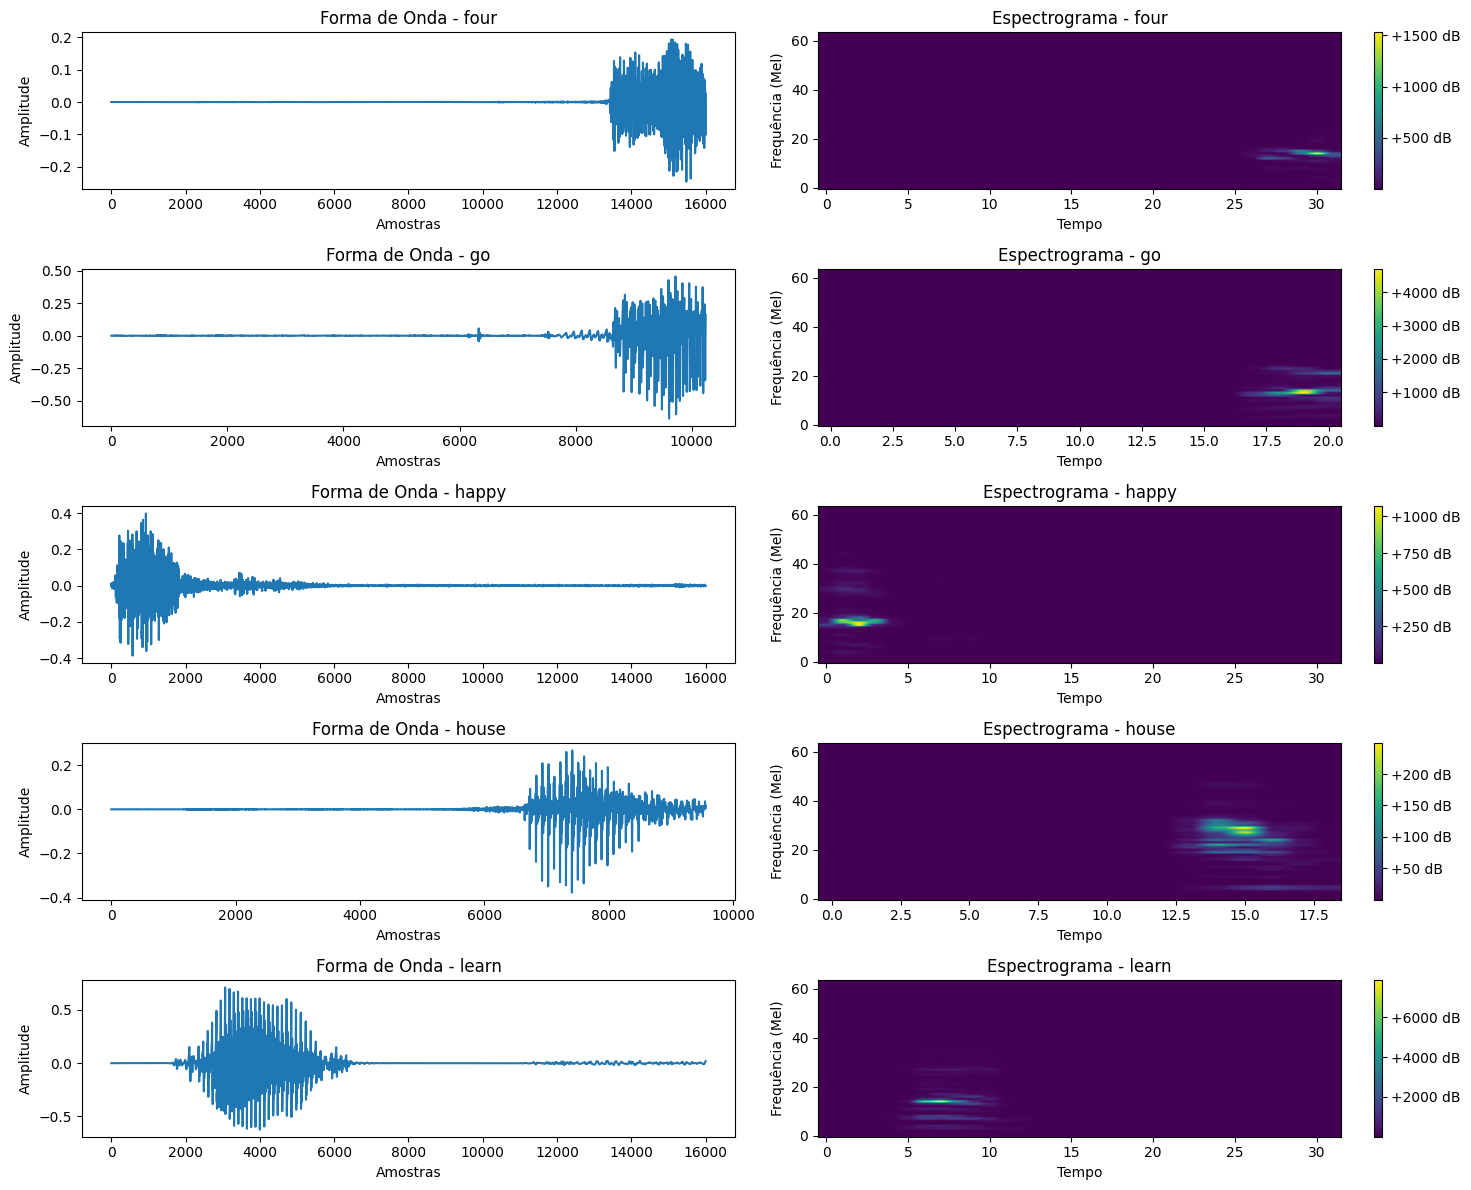

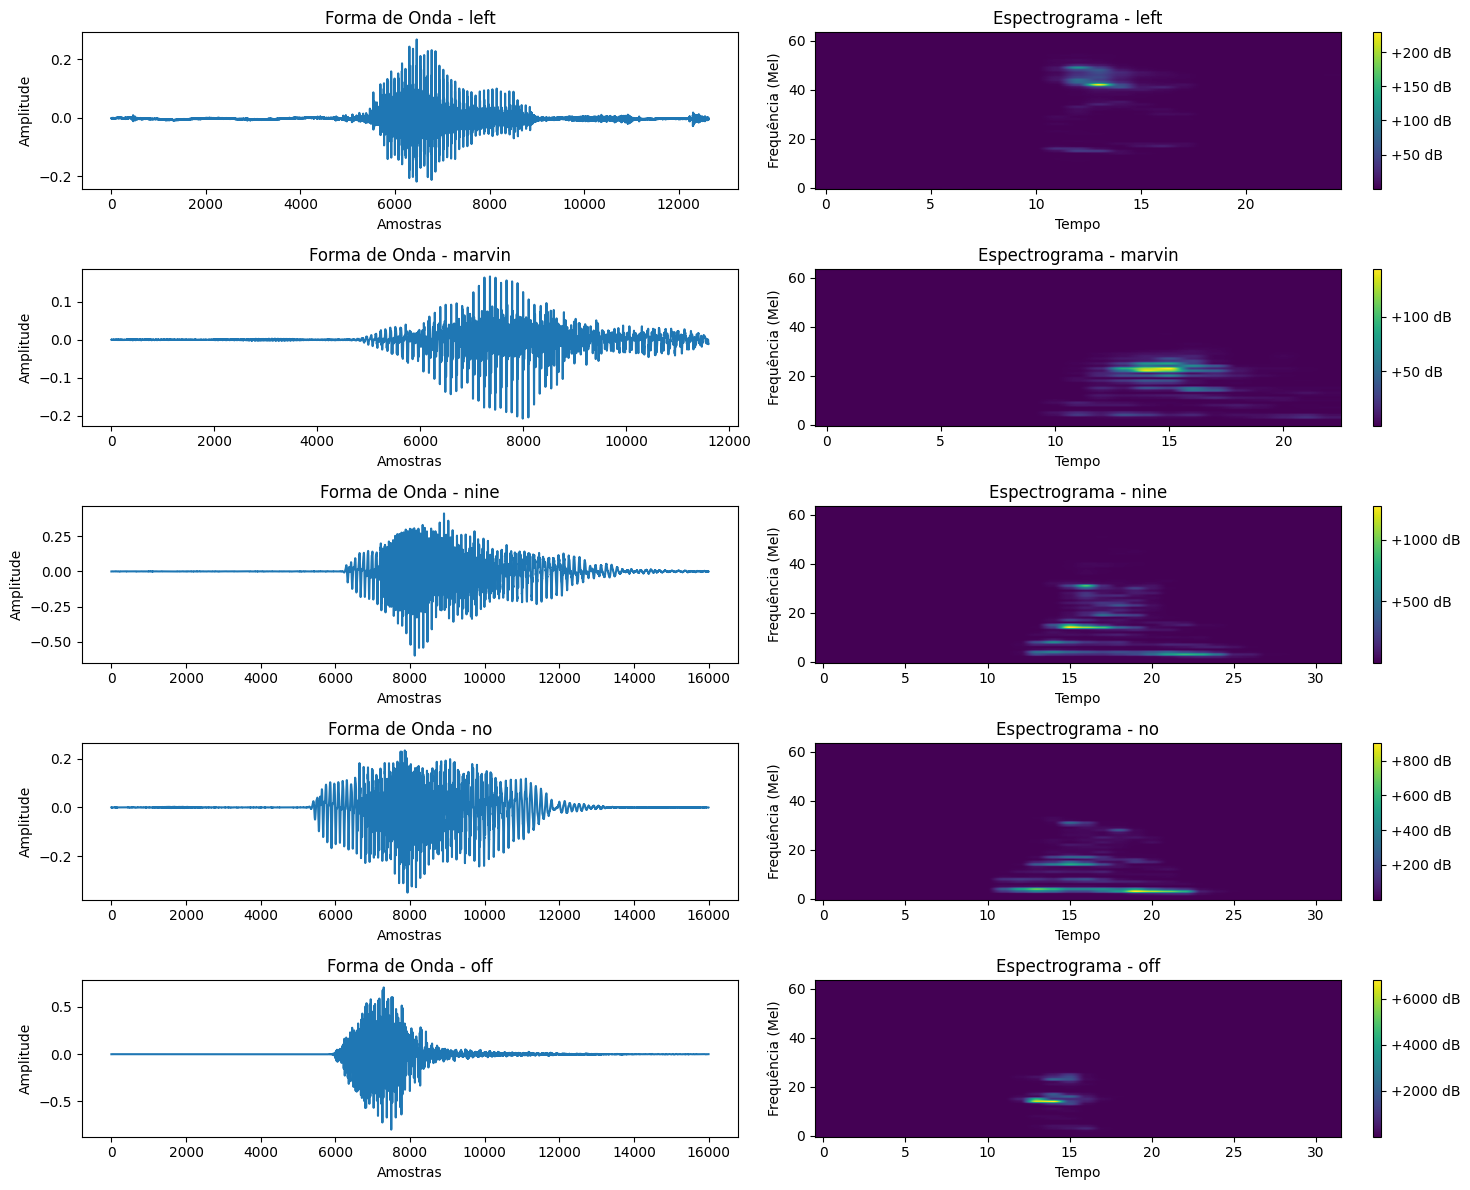

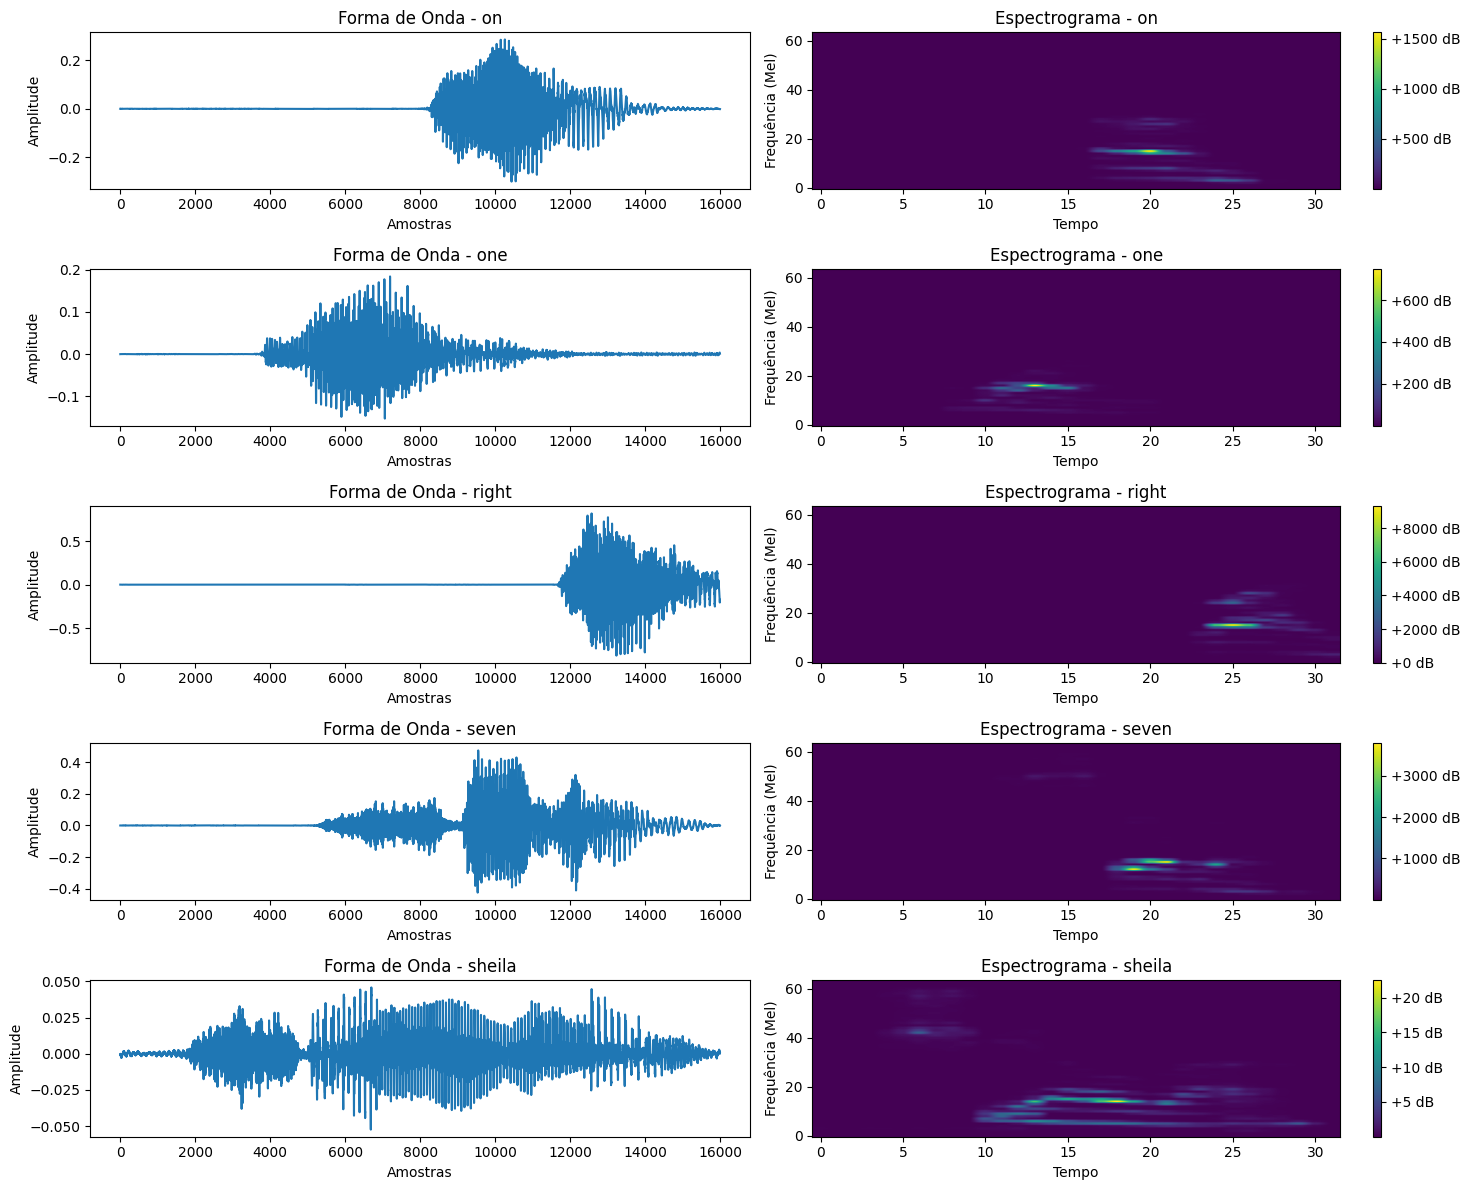

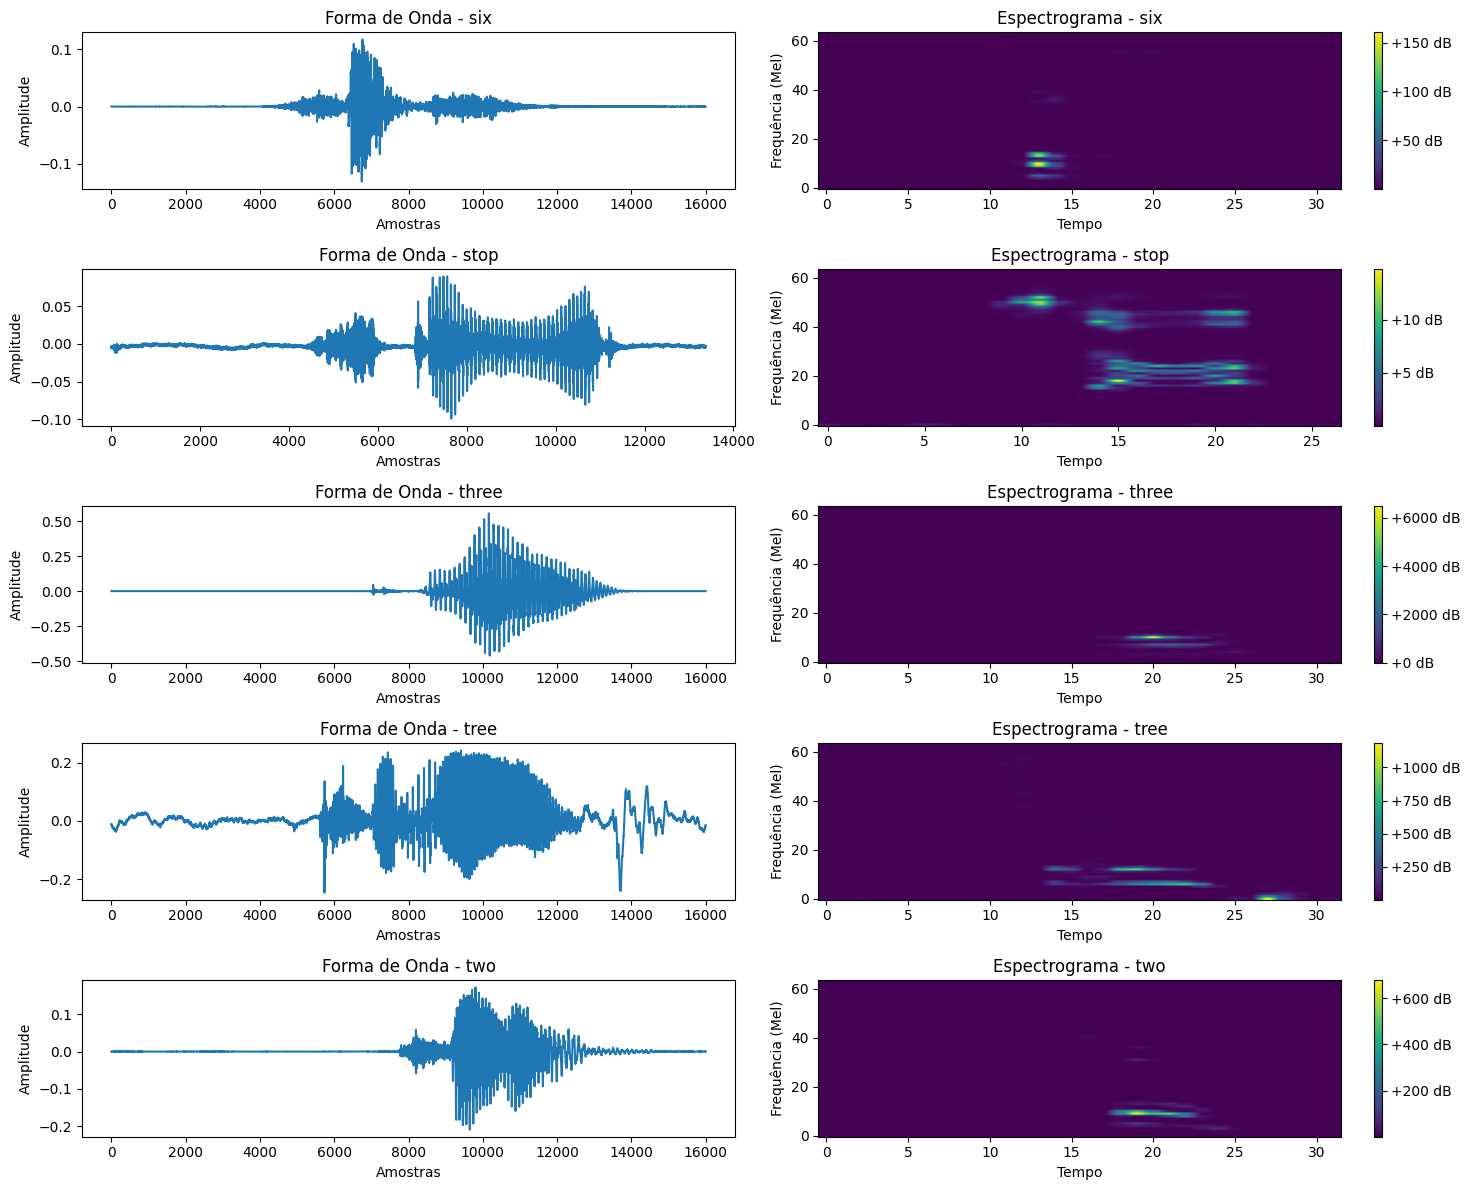

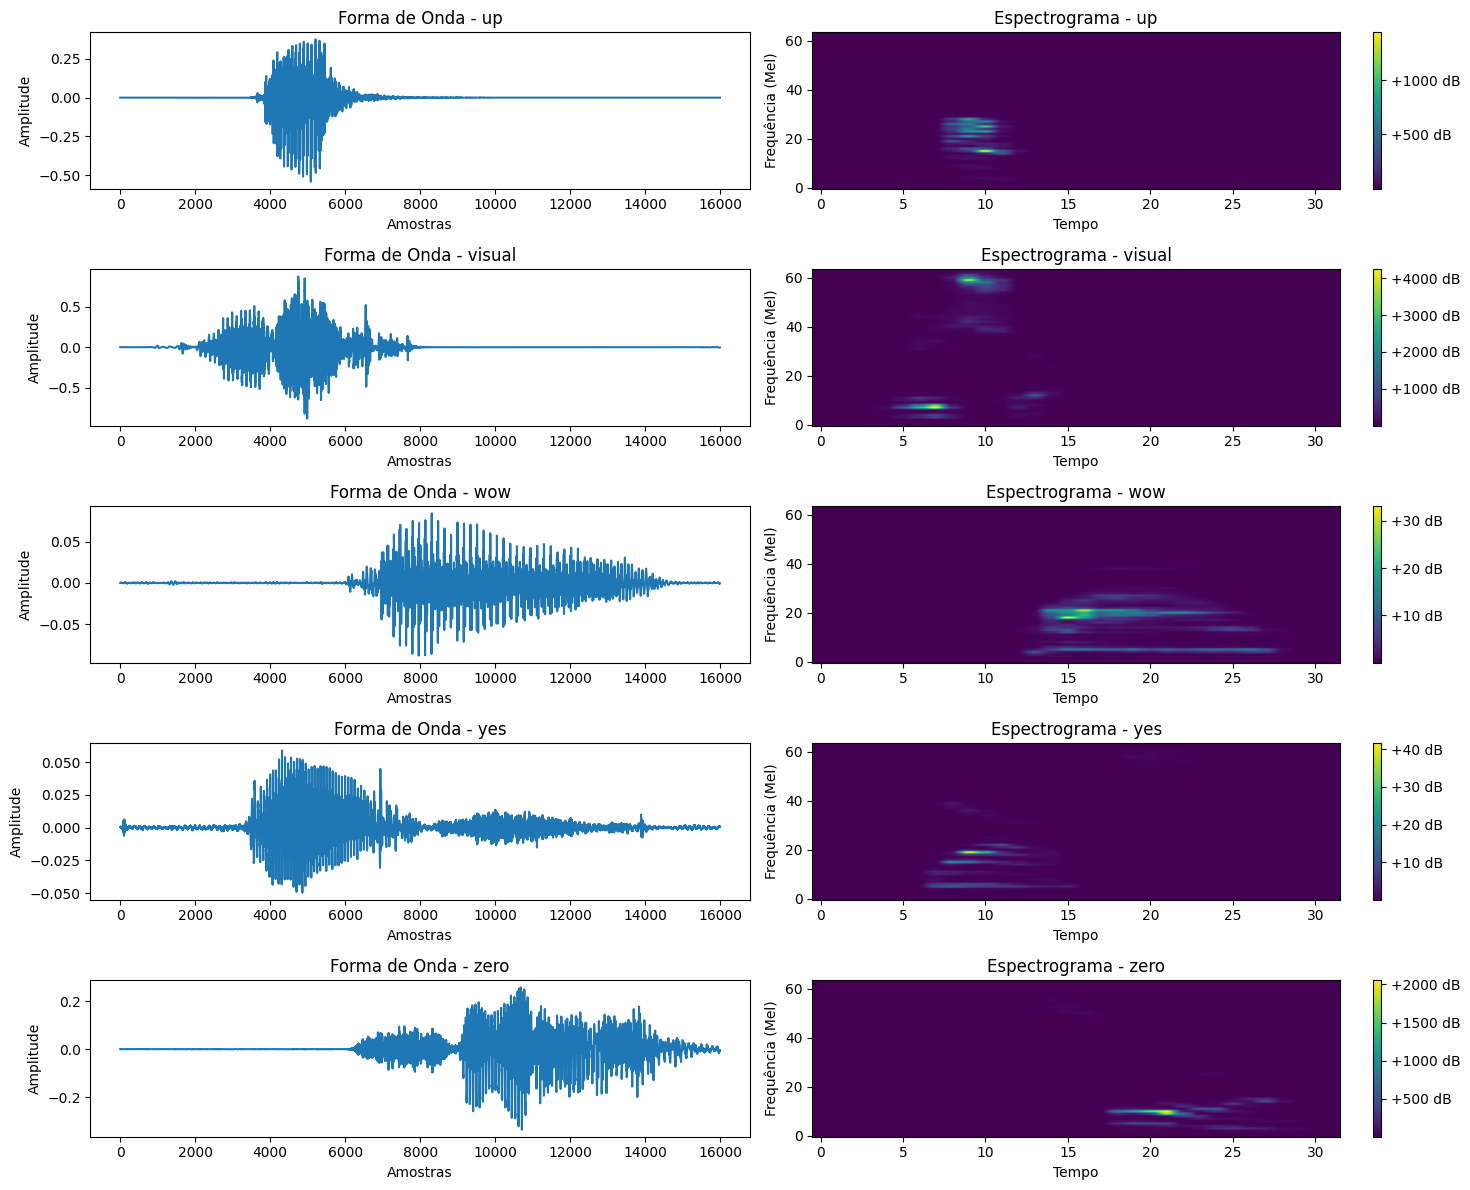

In [12]:
plot_waveforms_and_spectrograms()

In [13]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [14]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [15]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []
    
    max_length = max([waveform.shape[-1] for waveform, _, _, *_ in batch])
    
    for waveform, _, label, *_ in batch:
        if len(waveform.shape) == 3:
            waveform = waveform.squeeze(0)
        if len(waveform.shape) == 2:
            waveform = waveform.squeeze(0)
            
        if waveform.shape[-1] < max_length:
            padding_length = max_length - waveform.shape[-1]
            waveform = torch.nn.functional.pad(waveform, (0, padding_length))
            
        tensors.append(waveform)
        targets.append(label_to_index(label))
    
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)
    
    return tensors, targets

In [16]:
batch_size = 128

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [20]:
class SpeechCommandsClassifier(nn.Module):
    def __init__(self, base_model, num_labels, dropout_rate=0.3):
        super().__init__()
        self.base_model = base_model
        
        # Congelar todo o modelo base
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Descongelar apenas as 2 últimas camadas do encoder
        for i in range(2):
            for param in self.base_model.encoder.layers[-(i+1)].parameters():
                param.requires_grad = True
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(768)
        self.dense1 = nn.Linear(768, 384)
        
        self.dropout2 = nn.Dropout(dropout_rate)
        self.batch_norm2 = nn.BatchNorm1d(384)
        self.dense2 = nn.Linear(384, num_labels)

    def forward(self, input_values):
        outputs = self.base_model(input_values)
        hidden_states = outputs.last_hidden_state
        
        pooled = torch.mean(hidden_states, dim=1)
        
        x = self.dropout1(pooled)
        x = self.batch_norm1(x)
        x = F.relu(self.dense1(x))
        
        x = self.dropout2(x)
        x = self.batch_norm2(x)
        logits = self.dense2(x)
        
        return logits

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, n_epochs, device):
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(n_epochs):
        # Treino
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calcular métricas
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Atualizar scheduler
        scheduler.step(val_acc)
        
        # Salvar melhor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Novo melhor modelo salvo com acurácia: {val_acc:.2f}%")
        
        # Guardar histórico
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch: {epoch+1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("-" * 50)
    
    return history

In [22]:
num_labels = len(labels)
print(f"Número de classes: {num_labels}")

Número de classes: 35


In [23]:
base_model = AutoModel.from_pretrained("facebook/wav2vec2-base")

model = SpeechCommandsClassifier(
    base_model=base_model,
    num_labels=num_labels,
    dropout_rate=0.3
).to(device)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=2, 
    verbose=True
)

In [25]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=20,
    device=device
)

Novo melhor modelo salvo com acurácia: 64.96%
Epoch: 1/20
Train Loss: 2.7343, Train Acc: 30.83%
Val Loss: 1.4984, Val Acc: 64.96%
--------------------------------------------------
Novo melhor modelo salvo com acurácia: 89.49%
Epoch: 2/20
Train Loss: 1.3430, Train Acc: 70.85%
Val Loss: 0.5998, Val Acc: 89.49%
--------------------------------------------------
Novo melhor modelo salvo com acurácia: 92.49%
Epoch: 3/20
Train Loss: 0.8702, Train Acc: 80.99%
Val Loss: 0.3835, Val Acc: 92.49%
--------------------------------------------------
Novo melhor modelo salvo com acurácia: 92.99%
Epoch: 4/20
Train Loss: 0.6944, Train Acc: 83.96%
Val Loss: 0.3111, Val Acc: 92.99%
--------------------------------------------------
Novo melhor modelo salvo com acurácia: 93.49%
Epoch: 5/20
Train Loss: 0.5974, Train Acc: 85.46%
Val Loss: 0.2755, Val Acc: 93.49%
--------------------------------------------------
Epoch: 6/20
Train Loss: 0.5419, Train Acc: 86.56%
Val Loss: 0.2721, Val Acc: 92.99%
-----------

In [26]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Modo de avaliação
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    # Para matriz de confusão e outras métricas
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Não calcular gradientes
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)
            
            # Acumular loss
            test_loss += loss.item()
            
            # Obter predições
            _, predicted = torch.max(outputs.data, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
            
            # Guardar predições e labels para métricas
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            
    # Calcular métricas finais
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    
    # Calcular outras métricas usando sklearn
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"Resultados no conjunto de teste:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.2f}%")
    print("\nRelatório de classificação:")
    print(classification_report(all_labels, all_preds))
    
    # Retornar métricas para uso posterior se necessário
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_preds,
        'true_labels': all_labels
    }


In [27]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Carregar melhor modelo
test_metrics = test_model(model, test_loader, criterion, device)

Resultados no conjunto de teste:
Loss: 0.1707
Accuracy: 95.37%

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.95      0.98        21
           2       0.83      0.79      0.81        19
           3       0.89      0.89      0.89        19
           4       0.95      0.86      0.90        22
           5       0.95      0.98      0.96        41
           6       1.00      0.98      0.99        41
           7       1.00      0.98      0.99        44
           8       0.89      0.94      0.92        18
           9       0.92      0.75      0.83        16
          10       0.89      0.97      0.93        40
          11       0.95      1.00      0.98        40
          12       0.95      0.95      0.95        20
          13       0.95      1.00      0.97        19
          14       0.93      0.81      0.87        16
          15       0.98      0.95      0.96

In [30]:
def analyze_results(test_metrics):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(test_metrics['true_labels'], test_metrics['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()
    
    errors = np.array(test_metrics['predictions']) != np.array(test_metrics['true_labels'])
    error_indices = np.where(errors)[0]

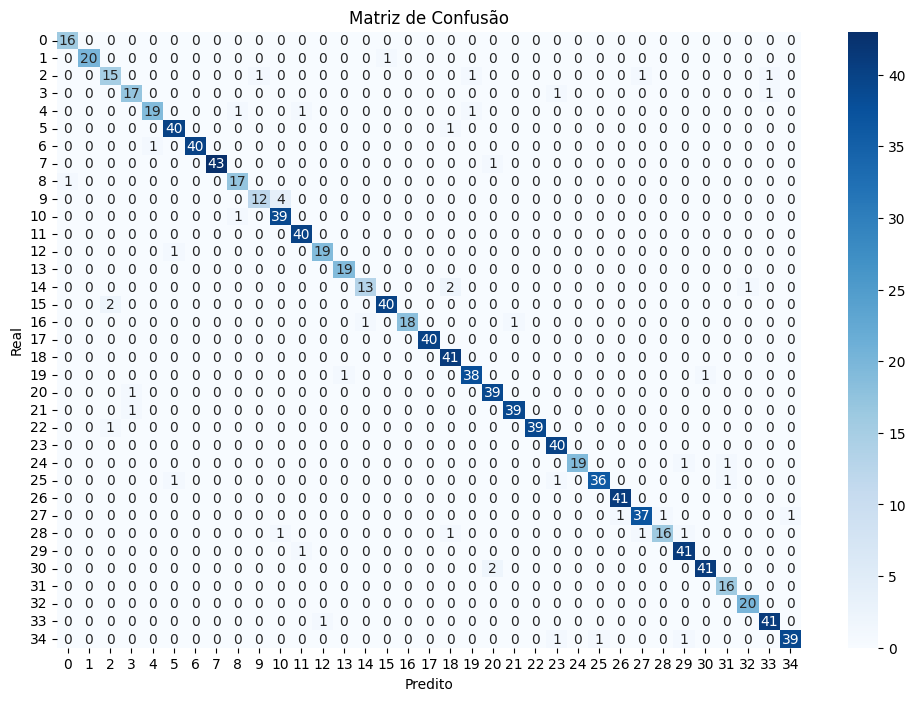

In [31]:
analyze_results(test_metrics)